In [36]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

### Change directories and file names to make rating as a directories' name

In [10]:
os.listdir("./aclImdb/train/pos")[2].split('_')[1].split('.')[0]

'10'

In [11]:
os.mkdir("./aclImdb_changed/")
os.mkdir("./aclImdb_changed/train/")
os.mkdir("./aclImdb_changed/test/")
for i in range(1, 11):
    os.mkdir(f"./aclImdb_changed/train/{i}")
for i in range(1, 11):
    os.mkdir(f"./aclImdb_changed/test/{i}")

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: './aclImdb_changed/'

In [4]:
for train_test_split in ['train', 'test']:
    for neg_pos_split in ['neg', 'pos']:
        for file_name in os.listdir("./aclImdb/{}/{}".format(train_test_split, neg_pos_split)):
            score_of_file_name = file_name.split('_')[1].split('.')[0]
            id_of_file_name = file_name.split('_')[0]
            
            file_src = "./aclImdb/{}/{}/{}".format(train_test_split,
                                                    neg_pos_split,
                                                    file_name)
            f_src = open(file_src, 'rb')
            
            file_dest = "./aclImdb_changed/{}/{}/{}_{}.txt".format(train_test_split,
                                                                   score_of_file_name,
                                                                   id_of_file_name,
                                                                   neg_pos_split)
            f_dest = open(file_dest, 'wb')
            
            shutil.copyfileobj(f_src, f_dest)
            
            f_src.close()
            f_dest.close()

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
label_mode = 'categorical'

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb_changed/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed,
    label_mode=label_mode)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb_changed/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    label_mode=label_mode)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb_changed/test',
    batch_size=batch_size,
    label_mode=label_mode)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 10 classes.
Using 20000 files for training.
Found 25000 files belonging to 10 classes.
Using 5000 files for validation.
Found 25000 files belonging to 10 classes.


In [39]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label.tolist().index(max(label))]})')

Review: b'Although I have enjoyed Bing Crosby in other movies, I find this movie to be particularly grating. Maybe because I\'m from a different era and a different country, but I found Crosby\'s continual references to the Good Old USA pleasant at first, trite after a while and then finally annoying. Don\'t get me wrong - I\'m not anti-American whatsoever - but it seemed that the English could do no right and/or needed this brave, oh so smart American visitor to show them the way. It\'s a "fish out of water" story, but unlike most movies of this sort, this time it\'s the "fish" who has the upper hand. To be fair to both myself and the movie, I have watched it a few times spaced over a few years and get the same impression each time.<br /><br />(I watched another Crosby movie last night - The Emperor\'s Waltz - and that, too, produced the same reaction in me. And to my surprise even my wife - who for what\'s it\'s worth is American - found the "in your face" attitude of American Crosby

In [40]:
bert_model_name = 'electra_small' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [41]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [42]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [44]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[-0.10836226  0.44823638 -0.34683406  0.19495142  0.6461417  -0.19015458
  0.88206446  0.9730518   0.5487044   0.09718803 -0.6218557  -0.817908  ]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.10878944  0.48249102 -0.3618404  ...  0.78575134 -0.92949957
   0.00239475]
 [ 0.02633602 -0.02841341 -0.6654847  ...  1.0874976  -0.9247099
  -0.631996  ]
 [ 0.0137741   0.58779514  0.5324823  ...  0.2326007  -1.1400315
   1.0107266 ]
 ...
 [ 1.1805729  -0.159688   -0.63374966 ... -0.29925543 -0.2618149
  -0.49652207]
 [ 1.124461    0.10477596 -0.55947626 ... -0.39726853 -0.30455184
  -0.5040226 ]
 [ 1.0742393   0.13643174 -0.46082553 ... -0.44207394 -0.2523386
  -0.508529  ]]


In [45]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [51]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor(
[[0.1484787  0.05579026 0.04361766 0.04087777 0.05426791 0.28982645
  0.09962881 0.09453437 0.08040337 0.09257461]], shape=(1, 10), dtype=float32)


In [58]:
def to_correct_predict(raw_predict):
    listed_predict = raw_predict.numpy().tolist()[0]
    
    correct_predict = listed_predict.index(max(listed_predict))
    
    return correct_predict

In [59]:
print(to_correct_predict(bert_raw_result))

5


In [64]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()

In [61]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [65]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [66]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/5
625/625 [==============================] - 2423s 4s/step - loss: 1.8947 - categorical_accuracy: 0.2905 - val_loss: 1.5885 - val_categorical_accuracy: 0.3848
Epoch 2/5
625/625 [==============================] - 2345s 4s/step - loss: 1.5675 - categorical_accuracy: 0.3927 - val_loss: 1.5442 - val_categorical_accuracy: 0.4020
Epoch 3/5
625/625 [==============================] - 2524s 4s/step - loss: 1.4721 - categorical_accuracy: 0.4273 - val_loss: 1.5083 - val_categorical_accuracy: 0.4106
Epoch 4/5
625/625 [==============================] - 2431s 4s/step - loss: 1.4011 - categorical_accuracy: 0.4518 - val_loss: 1.5154 - val_categorical_accuracy: 0.4128
Epoch 5/5
625/625 [==============================] - 2403s 4s/step - loss: 1.3527 - categorical_accuracy: 0.4667 - val_loss: 1.5368 - val_categorical_accuracy: 0.4084


In [70]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 825s 1s/step - loss: 1.5395 - categorical_accuracy: 0.4130
Loss: 1.5395350456237793
Accuracy: 0.4129599928855896


In [71]:
dataset_name = 'imdb_changed'
saved_model_path = './{}_electra_small_for_score_correct_output'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [83]:
classifier_model.save('electra_small.h5', include_optimizer=False)

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


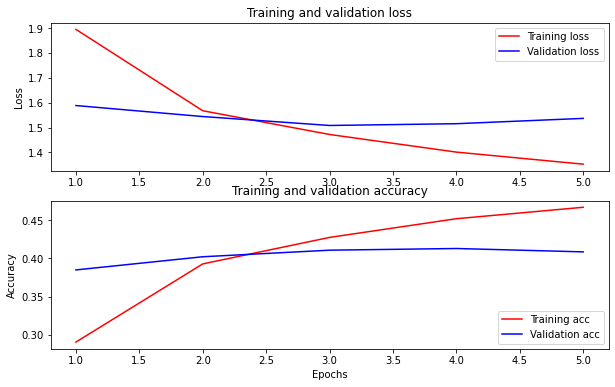

In [74]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [81]:
bert_raw_result_after_train = classifier_model(tf.constant(text_test))

print(to_correct_predict(bert_raw_result_after_train))

1


In [82]:
reloaded_model = tf.saved_model.load('imdb_changed_electra_small_for_score')

In [80]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

results = classifier_model.predict(examples)

print('Results from the saved model:')
print_my_examples(examples, results)

Results from the saved model:
input: this is such an amazing movie! : score: [[4.3772785e-03 8.4275746e-01 1.0252289e-03 1.6381406e-03 5.6123390e-04
  3.4833269e-03 3.1467138e-03 2.0466579e-02 2.9695425e-02 9.2848711e-02]
 [2.4477125e-03 8.4807968e-01 5.1386288e-04 9.9482341e-04 3.7021900e-04
  1.5307601e-03 1.4425990e-03 1.6541293e-02 2.9938763e-02 9.8140292e-02]
 [1.2784018e-01 2.0352257e-02 2.6236948e-01 3.4834433e-01 1.7733039e-01
  4.8123734e-04 1.3268066e-03 2.7643111e-02 1.8808095e-02 1.5504043e-02]
 [3.9272973e-01 6.1045559e-03 2.9293638e-01 1.8633583e-01 1.0181992e-01
  6.5690110e-04 8.9793175e-04 9.9845063e-03 4.6071783e-03 3.9270297e-03]
 [8.3292568e-01 7.1347831e-04 1.0651203e-01 3.4918033e-02 2.1031059e-02
  5.8382761e-04 9.4223744e-04 1.0717174e-03 4.6044143e-04 8.4150746e-04]]
input: The movie was great!           : score: [[4.3772785e-03 8.4275746e-01 1.0252289e-03 1.6381406e-03 5.6123390e-04
  3.4833269e-03 3.1467138e-03 2.0466579e-02 2.9695425e-02 9.2848711e-02]
 [2.4